# 0. Installs, Imports and API Keys

In [1]:
# RUN THIS CELL FIRST!
!pip install -q langchain==0.0.150 pypdf pandas matplotlib tiktoken textract transformers openai==0.27.6 faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.4/648.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 38.5 MB/s

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain

In [3]:
os.environ["OPENAI_API_KEY"] = "{your_api_key}"

# 1. Loading PDFs and chunking with LangChain

In [4]:
# You MUST add your PDF to local files in this notebook (folder icon on left hand side of screen)

# Simple method - Split by pages
loader = PyPDFLoader("/content/CompaniesAct2013.pdf")
pages = loader.load_and_split()
print(pages[0])

# SKIP TO STEP 2 IF YOU'RE USING THIS METHOD
chunks = pages

page_content='1 \n THE COMPANIES ACT, 2013  \n__________________  \nARRANGEMENT OF SECTION S \n__________________  \nCHAPTER I  \nPRELIMINARY  \nSECTIONS  \n1. Short title, extent, commencement and application.  \n2. Definitions.  \n \nCHAPTER II  \nINCORPORATION OF COMPANY AND MATTERS INCIDENTAL THERETO  \n3. Formation of company.  \n4. Memorandum.  \n5. Articles.  \n6. Act to override memorandum, articles, etc.  \n7. Incorporation of company.  \n8. Formation of companies with charitable objects, etc.  \n9. Effect of registration.  \n10. Effect of memorandum and articles.  \n11. [Omitted ]. \n12. Registered office of company.  \n13. Alteration of memorandum.  \n14. Alteration of articles.  \n15. Alteration of memorandum or articles to be noted in every copy.  \n16. Rectification of name of company.  \n17. Copies of memorandum, articles,  etc., to be given to members.  \n18. Conversion of companies already registered.  \n19. Subsidiary company not to hold shares in its holding company.

In [5]:
# Advanced method - Split by chunk

# Step 1: Convert PDF to text
import textract
doc = textract.process("/content/CompaniesAct2013.pdf")

# Step 2: Save to .txt and reopen (helps prevent issues)
with open('CompaniesAct2013.txt', 'w') as f:
    f.write(doc.decode('utf-8'))

with open('CompaniesAct2013.txt', 'r') as f:
    text = f.read()

# Step 3: Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# Step 4: Split text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 512,
    chunk_overlap  = 24,
    length_function = count_tokens,
)

chunks = text_splitter.create_documents([text])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1062 > 1024). Running this sequence through the model will result in indexing errors


In [6]:
# Result is many LangChain 'Documents' around 500 tokens or less (Recursive splitter sometimes allows more tokens to retain context)
type(chunks[0])

langchain.schema.Document

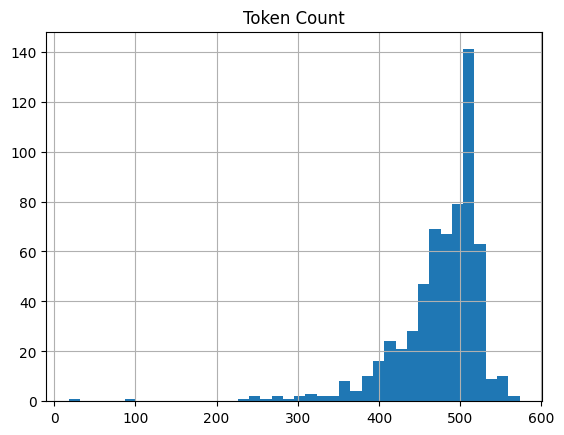

In [7]:
# Quick data visualization to ensure chunking was successful

# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=40, )

# Show the plot
plt.show()

# 2. Embed text and store embeddings

In [8]:
# Get embedding model
embeddings = OpenAIEmbeddings()

# Create vector database
db = FAISS.from_documents(chunks, embeddings)

# 3. Setup retrieval function

In [9]:
# Check similarity search is working
query = "how to incorporate a company"
docs = db.similarity_search(query)
docs[0]

Document(page_content='thirty days of its incorporation in such manner as may be prescribed. \n\n(3) Every company shall— \n\n(a) paint or affix its name, and the address of its registered office, and keep the same painted or \naffixed, on the outside of every office or place in which its business is carried on, in a conspicuous \nposition, in legible letters, and if the characters employed therefor are not those of the language or of \none of the languages in general use in that locality, also in the characters of that language or of one of \nthose languages; \n\n1[(b) have its name engraved in legible characters on its seal, if any;] \n\n(c)  get  its  name,  address  of  its  registered  office  and  the  Corporate  Identity  Number  along  with \ntelephone number, fax number, if any, e-mail and website addresses, if any, printed in all its business \nletters, billheads, letter papers and in all its notices and other official publications; and \n\n(d)  have  its  name  printed  on  

In [17]:
# Create QA chain to integrate similarity search with user queries (answer query from knowledge base)

chain = load_qa_chain(OpenAI(temperature=0, model="gpt-3.5-turbo",), chain_type="stuff")

query = "how to incorporate a company?"
docs = db.similarity_search(query)

chain.run(input_documents=docs, question=query)

# 5. Create chatbot with chat memory (OPTIONAL)

In [11]:
from IPython.display import display
import ipywidgets as widgets

# Create conversation chain that uses our vectordb as retriver, this also allows for chat history management
qa = ConversationalRetrievalChain.from_llm(OpenAI(temperature=0.1), db.as_retriever())

In [17]:
chat_history = []

def on_submit(_):
    query = input_box.value
    input_box.value = ""

    if query.lower() == 'exit':
        print("Thank you for using the State of the Union chatbot!")
        return

    result = qa({"question": query, "chat_history": chat_history})
    chat_history.append((query, result['answer']))

    display(widgets.HTML(f'<b>User:</b> {query}'))
    display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> {result["answer"]}'))

print("Welcome to the Transformers chatbot! Type 'exit' to stop.")

input_box = widgets.Text(placeholder='Please enter your question:')
input_box.on_submit(on_submit)

display(input_box)